In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Mon Oct 20 00:55:54 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.0/model_spec/2025_10_09_17_56_46/results

In [3]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [4]:
# Results directory containing model 7 results for all locations
!ls -halt results/model7.0/model_spec/2025_10_09_17_56_46/results

total 614M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct  9 20:55 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 6.5K Oct  9 20:54 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  12M Oct  9 20:54 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  11M Oct  9 20:53 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 7.1M Oct  9 20:53 counts_bbbm_tests.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  17M Oct  9 20:52 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 194M Oct  9 20:52 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 106M Oct  9 20:51 person_time_treatment.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  75M Oct  9 20:50 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 9.0M Oct  9 20:48 counts_new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  23

In [5]:
!ls results/model7.0/model_spec/2025_10_09_17_56_46/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [6]:
locations = [
    # 'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    'Japan',
    'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

model_number = '7.0' # Artifacts are stored here
run_subdirectories = [
    'results/model7.0/model_spec/2025_10_09_17_56_46/',
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'Japan': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf',
 'Spain': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'}

In [7]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.0/model_spec/2025_10_09_17_56_46/results/'}

# Define some ordered Categorical dtypes

In [8]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_categorical_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [9]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['Japan']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [10]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [11]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
0,0.527516,0.495529,0.464333,0.576056,0.478925,0.458396,0.541982,0.520483,0.53923,0.514836,...,0.485136,0.498684,0.503797,0.432717,0.462276,0.481699,0.569136,0.502568,0.4362,0.512734


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [12]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [13]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        colname_to_dtype=colname_to_categorical_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")
        
        print(location_filter)

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            convert_dtypes(df, colname_to_dtype, inplace=True)
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def convert_dtypes(df, colname_to_dtype, inplace=False):
    if not inplace:
        df = df.copy()
    for colname, dtype in colname_to_dtype.items():
        if colname in df:
            df[colname] = df[colname].astype(dtype)

    if not inplace:
        return df
    else:
        return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


In [14]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    # raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


,age_group,artifact_path,event_year,input_draw,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,baseline,Male,1.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing,Male,1.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing_and_treatment,Female,0.0,Japan
...,...,...,...,...,...,...,...,...
341995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,273,baseline,Male,0.0,Spain
341996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,273,bbbm_testing,Female,0.0,Spain
341997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,273,bbbm_testing,Male,0.0,Spain
341998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,273,bbbm_testing_and_treatment,Female,0.0,Spain


In [15]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342000 entries, 0 to 341999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      342000 non-null  category
 1   artifact_path  342000 non-null  category
 2   event_year     342000 non-null  int16   
 3   input_draw     342000 non-null  category
 4   scenario       342000 non-null  category
 5   sex            342000 non-null  category
 6   value          342000 non-null  float64 
 7   location       342000 non-null  category
dtypes: category(6), float64(1), int16(1)
memory usage: 5.2 MB


In [16]:
new_sims['scenario']

0                           baseline
1                           baseline
2                       bbbm_testing
3                       bbbm_testing
4         bbbm_testing_and_treatment
                     ...            
341995                      baseline
341996                  bbbm_testing
341997                  bbbm_testing
341998    bbbm_testing_and_treatment
341999    bbbm_testing_and_treatment
Name: scenario, Length: 342000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [17]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [18]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
129.283532 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,susceptible_to_treatment,0.000000,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,start_treatment,0.000000,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,full_effect_long,0.000000,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,full_effect_short,0.000000,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,waning_effect_long,0.000000,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,waning_effect_long,0.000000,Spain
6155996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,waning_effect_short,0.000000,Spain
6155997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,no_effect_after_long,88.197125,Spain
6155998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,no_effect_after_short,10.962355,Spain


In [19]:
person_time_treatment.event_year.unique()

array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
      dtype=int16)

In [20]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [21]:
person_time_treatment.query("sub_entity == 'start_treatment'")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,start_treatment,0.0,Japan
10,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Male,start_treatment,0.0,Japan
19,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,second,Female,start_treatment,0.0,Japan
28,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,second,Male,start_treatment,0.0,Japan
37,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,bbbm_testing,first,Female,start_treatment,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155956,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing,second,Male,start_treatment,0.0,Spain
6155965,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,first,Female,start_treatment,0.0,Spain
6155974,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,first,Male,start_treatment,0.0,Spain
6155983,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Female,start_treatment,0.0,Spain


# Load treatment transition counts

In [22]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
114.919636 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,transition_count,baseline,first,Female,start_treatment_to_full_effect_long,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,transition_count,baseline,first,Female,start_treatment_to_full_effect_short,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,transition_count,baseline,first,Female,full_effect_long_to_waning_effect_long,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,transition_count,baseline,first,Female,full_effect_short_to_waning_effect_short,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,transition_count,baseline,first,Female,waning_effect_long_to_no_effect_after_long,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5471995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing_and_treatment,second,Male,full_effect_short_to_waning_effect_short,0.0,Spain
5471996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing_and_treatment,second,Male,waning_effect_long_to_no_effect_after_long,0.0,Spain
5471997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing_and_treatment,second,Male,waning_effect_short_to_no_effect_after_short,0.0,Spain
5471998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing_and_treatment,second,Male,susceptible_to_treatment_to_start_treatment,0.0,Spain


In [23]:
transition_count_treatment.sub_entity.unique()

['start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_start_treatment', 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_start_treatment', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [24]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
2565639,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,transition_count,bbbm_testing,first,Female,susceptible_to_treatment_to_no_effect_never_tr...,55.0,Japan
2565647,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,transition_count,bbbm_testing,first,Male,susceptible_to_treatment_to_no_effect_never_tr...,27.0,Japan
2565655,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,transition_count,bbbm_testing,second,Female,susceptible_to_treatment_to_no_effect_never_tr...,18.0,Japan
2565663,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,transition_count,bbbm_testing,second,Male,susceptible_to_treatment_to_no_effect_never_tr...,9.0,Japan
2565735,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,89,transition_count,bbbm_testing,first,Female,susceptible_to_treatment_to_no_effect_never_tr...,57.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377471,80_to_84,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,258,transition_count,bbbm_testing,second,Male,susceptible_to_treatment_to_no_effect_never_tr...,24.0,Spain
4377543,80_to_84,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing,first,Female,susceptible_to_treatment_to_no_effect_never_tr...,29.0,Spain
4377551,80_to_84,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing,first,Male,susceptible_to_treatment_to_no_effect_never_tr...,16.0,Spain
4377559,80_to_84,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,transition_count,bbbm_testing,second,Female,susceptible_to_treatment_to_no_effect_never_tr...,24.0,Spain


In [25]:
non_treatment_transitions.scenario.unique()

['bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [26]:
list(non_treatment_transitions.sub_entity.unique())

['susceptible_to_treatment_to_no_effect_never_treated']

# Transform treatment transition counts into more useful form

In [27]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

19.163643 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,location,measure,scenario,sex,sub_entity,value,from_state,to_state
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,Japan,transition_count,bbbm_testing_and_treatment,Female,start_treatment_to_full_effect_long,0.0,start_treatment,full_effect_long
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,Japan,transition_count,bbbm_testing_and_treatment,Female,start_treatment_to_full_effect_short,0.0,start_treatment,full_effect_short
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,Japan,transition_count,bbbm_testing_and_treatment,Female,full_effect_long_to_waning_effect_long,0.0,full_effect_long,waning_effect_long
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,Japan,transition_count,bbbm_testing_and_treatment,Female,full_effect_short_to_waning_effect_short,0.0,full_effect_short,waning_effect_short
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,Japan,transition_count,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,0.0,waning_effect_long,no_effect_after_long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,Spain,transition_count,bbbm_testing_and_treatment,Male,full_effect_short_to_waning_effect_short,0.0,full_effect_short,waning_effect_short
911996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,Spain,transition_count,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,0.0,waning_effect_long,no_effect_after_long
911997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,Spain,transition_count,bbbm_testing_and_treatment,Male,waning_effect_short_to_no_effect_after_short,0.0,waning_effect_short,no_effect_after_short
911998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,Spain,transition_count,bbbm_testing_and_treatment,Male,susceptible_to_treatment_to_start_treatment,0.0,susceptible_to_treatment,start_treatment


In [28]:
treatment_transitions.to_state

0                full_effect_long
1               full_effect_short
2              waning_effect_long
3             waning_effect_short
4            no_effect_after_long
                   ...           
911995        waning_effect_short
911996       no_effect_after_long
911997      no_effect_after_short
911998            start_treatment
911999    no_effect_never_treated
Name: to_state, Length: 912000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'start_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'start_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [29]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'start_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

In [30]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through 80-84
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [31]:
# Verify that no one outside the eligible age groups starts treatment
treatment_transitions.query(
    "to_state == 'start_treatment'"
    " and age_group not in @treatment_eligible_age_groups"
).value.unique()

array([0.])

In [32]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the eligible age groups
treatment_transitions.query(
    "to_state == 'start_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [33]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

,event_year,input_draw,scenario,location,to_state,value,numerator_measure,denominator_measure,multiplier
0,2030,2,bbbm_testing_and_treatment,Japan,start_treatment,0.803723,transition_count,transition_count,1
1,2030,2,bbbm_testing_and_treatment,Japan,no_effect_never_treated,0.196277,transition_count,transition_count,1
2,2030,2,bbbm_testing_and_treatment,Spain,start_treatment,0.437059,transition_count,transition_count,1
3,2030,2,bbbm_testing_and_treatment,Spain,no_effect_never_treated,0.562941,transition_count,transition_count,1
4,2030,13,bbbm_testing_and_treatment,Japan,start_treatment,0.802482,transition_count,transition_count,1
...,...,...,...,...,...,...,...,...,...
7095,2100,480,bbbm_testing_and_treatment,Spain,no_effect_never_treated,0.311064,transition_count,transition_count,1
7096,2100,499,bbbm_testing_and_treatment,Japan,start_treatment,0.797985,transition_count,transition_count,1
7097,2100,499,bbbm_testing_and_treatment,Japan,no_effect_never_treated,0.202015,transition_count,transition_count,1
7098,2100,499,bbbm_testing_and_treatment,Spain,start_treatment,0.695358,transition_count,transition_count,1


In [34]:
initiate_vs_not.to_state.unique()

['start_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'start_treatment', 'waning_effect_long', 'waning_effect_short']

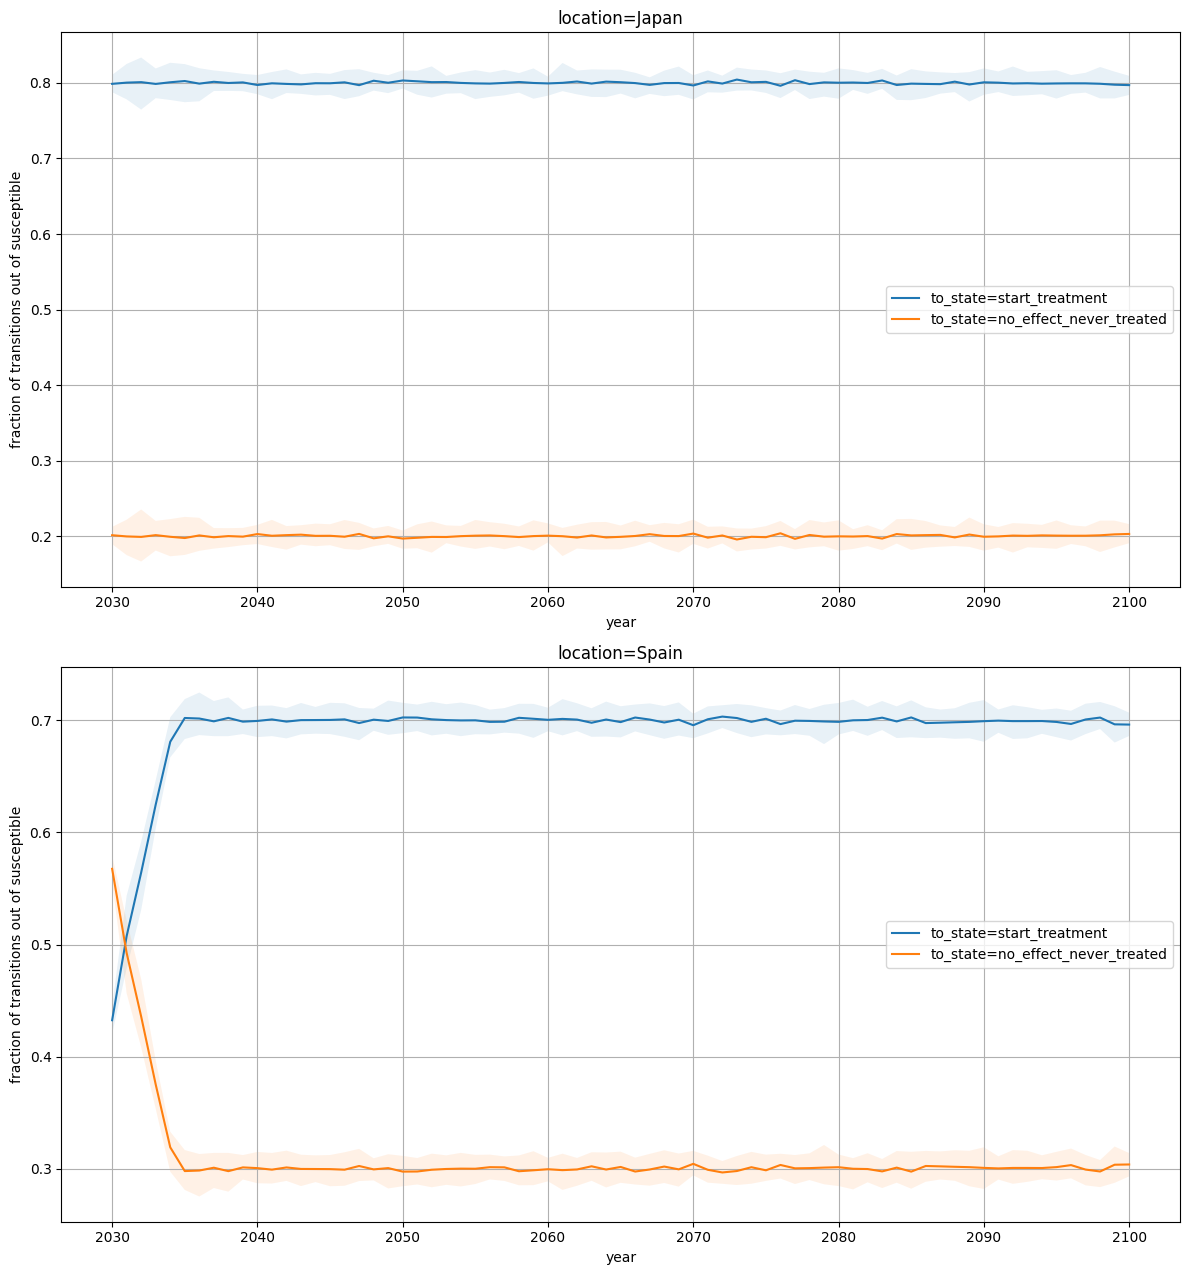

In [35]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [36]:
treatment_transitions.from_state.unique()

['start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [37]:
# This gives the fraction of the total transitions out of
# 'start_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'start_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

,input_draw,scenario,location,to_state,value,numerator_measure,denominator_measure,multiplier
0,2,bbbm_testing_and_treatment,Japan,full_effect_long,0.899560,transition_count,transition_count,1
1,2,bbbm_testing_and_treatment,Japan,full_effect_short,0.100440,transition_count,transition_count,1
2,2,bbbm_testing_and_treatment,Spain,full_effect_long,0.900450,transition_count,transition_count,1
3,2,bbbm_testing_and_treatment,Spain,full_effect_short,0.099550,transition_count,transition_count,1
4,13,bbbm_testing_and_treatment,Japan,full_effect_long,0.900718,transition_count,transition_count,1
...,...,...,...,...,...,...,...,...
95,480,bbbm_testing_and_treatment,Spain,full_effect_short,0.101087,transition_count,transition_count,1
96,499,bbbm_testing_and_treatment,Japan,full_effect_long,0.899899,transition_count,transition_count,1
97,499,bbbm_testing_and_treatment,Japan,full_effect_short,0.100101,transition_count,transition_count,1
98,499,bbbm_testing_and_treatment,Spain,full_effect_long,0.900082,transition_count,transition_count,1


In [38]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
0.899560 / 0.100440

8.956192751891678

In [39]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'start_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,24,bbbm_testing_and_treatment,Japan,9.152278,transition_count,transition_count,1
1,24,bbbm_testing_and_treatment,Spain,9.047761,transition_count,transition_count,1
2,89,bbbm_testing_and_treatment,Japan,8.978769,transition_count,transition_count,1
3,89,bbbm_testing_and_treatment,Spain,8.999547,transition_count,transition_count,1
4,346,bbbm_testing_and_treatment,Japan,8.948385,transition_count,transition_count,1
5,346,bbbm_testing_and_treatment,Spain,9.008832,transition_count,transition_count,1
6,499,bbbm_testing_and_treatment,Japan,8.989879,transition_count,transition_count,1
7,499,bbbm_testing_and_treatment,Spain,9.008226,transition_count,transition_count,1
8,2,bbbm_testing_and_treatment,Japan,8.956227,transition_count,transition_count,1
9,2,bbbm_testing_and_treatment,Spain,9.045190,transition_count,transition_count,1


In [40]:
summarize_sim_data(complete_to_discontinue_ratio)

count  \
denominator_measure location multiplier numerator_measure scenario                            
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment   25.0   
                    Spain    1          transition_count  bbbm_testing_and_treatment   25.0   

                                                                                          mean  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  8.996830   
                    Spain    1          transition_count  bbbm_testing_and_treatment  9.020156   

                                                                                           std  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  0.098536   
                    Spain    1          transition_count  bbbm_testing_and_treatment  0.097999   

                                                                                           min  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  8.821734   
                    Spain    1          transition_count  bbbm_testing_and_treatment  8.815459   

                                                                                         lower  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  8.826032   
                    Spain    1          transition_count  bbbm_testing_and_treatment  8.860204   

                                                                                           50%  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  8.989879   
                    Spain    1          transition_count  bbbm_testing_and_treatment  9.008226   

                                                                                         upper  \
denominator_measure location multiplier numerator_measure scenario                               
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  9.154535   
                    Spain    1          transition_count  bbbm_testing_and_treatment  9.208298   

                                                                                           max  
denominator_measure location multiplier numerator_measure scenario                              
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment  9.157920  
                    Spain    1          transition_count  bbbm_testing_and_treatment  9.216917

In [41]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location multiplier numerator_measure scenario                   to_state                   
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                     full_effect_short   25.0   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                     full_effect_short   25.0   

                                                                                                            mean  \
denominator_measure location multiplier numerator_measure scenario                   to_state                      
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899959   
                                                                                     full_effect_short  0.100041   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900192   
                                                                                     full_effect_short  0.099808   

                                                                                                             std  \
denominator_measure location multiplier numerator_measure scenario                   to_state                      
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000987   
                                                                                     full_effect_short  0.000987   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000975   
                                                                                     full_effect_short  0.000975   

                                                                                                             min  \
denominator_measure location multiplier numerator_measure scenario                   to_state                      
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898185   
                                                                                     full_effect_short  0.098445   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898120   
                                                                                     full_effect_short  0.097877   

                                                                                                           lower  \
denominator_measure location multiplier numerator_measure scenario                   to_state                      
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898230   
                                                                                     full_effect_short  0.098478   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898581   
                                                                                     full_effect_short  0.097960   

                                                                                                             50%  \
denominator_measure location multiplier numerator_measure scenario                   to_state                      
transition_count    Japan    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899899   
                                                                                     full_effect_short  0.100101   
                    Spain    1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900082   
                                                         

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'start_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'start_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [42]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [43]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [44]:
# Compute ratio of person-time in each state to the person-time in the
# "start_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'start_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030 and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

,event_year,input_draw,scenario,location,sub_entity,value,numerator_measure,denominator_measure,multiplier
0,2030,2,bbbm_testing_and_treatment,Japan,start_treatment,1.000000,person_time,person_time,1
1,2030,2,bbbm_testing_and_treatment,Japan,full_effect_long,0.000000,person_time,person_time,1
2,2030,2,bbbm_testing_and_treatment,Japan,full_effect_short,0.000000,person_time,person_time,1
3,2030,2,bbbm_testing_and_treatment,Japan,waning_effect_long,0.000000,person_time,person_time,1
4,2030,2,bbbm_testing_and_treatment,Japan,waning_effect_short,0.000000,person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
17745,2100,499,bbbm_testing_and_treatment,Spain,start_treatment,1.000000,person_time,person_time,1
17746,2100,499,bbbm_testing_and_treatment,Spain,full_effect_long,8.994819,person_time,person_time,1
17747,2100,499,bbbm_testing_and_treatment,Spain,full_effect_short,0.099859,person_time,person_time,1
17748,2100,499,bbbm_testing_and_treatment,Spain,waning_effect_long,10.176166,person_time,person_time,1


In [45]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['start_treatment', 'duration']
)
tx_state_durations


,duration,population_fraction,target_person_time_ratio
sub_entity,,,
start_treatment,0.5,1.0,1.0
full_effect_long,5.0,0.9,9.0
full_effect_short,0.5,0.1,0.1
waning_effect_long,9.0,0.9,16.2
waning_effect_short,2.5,0.1,0.5


In [46]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                     duration  pop_frac  pt_ratio
sub_entity                                       
start_treatment           0.5       1.0       1.0
full_effect_long          5.0       0.9       9.0
full_effect_short         0.5       0.1       0.1
waning_effect_long        9.0       0.9      16.2
waning_effect_short       2.5       0.1       0.5


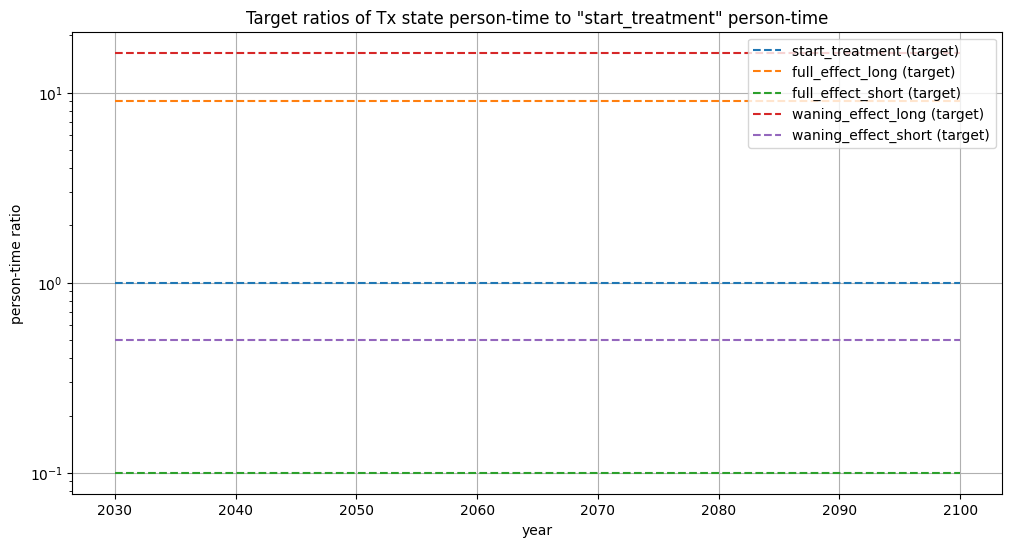

In [47]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "start_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

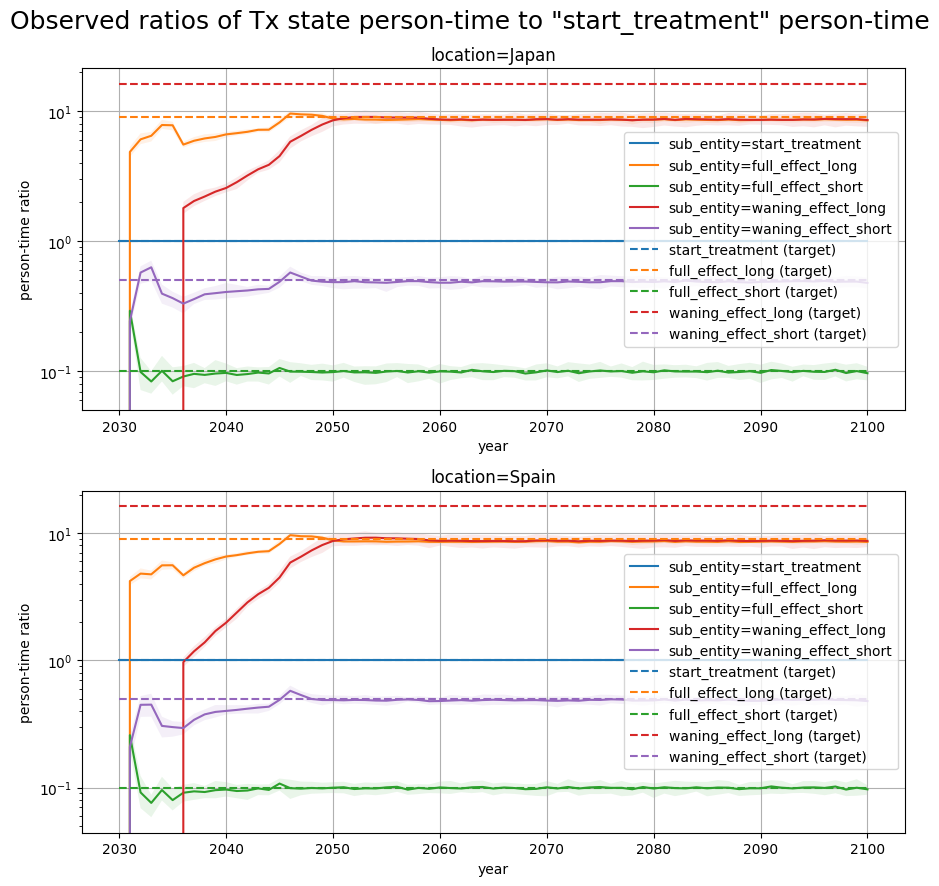

In [48]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "start_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is close to the target duration
of 9 years. I don't know why.

In [49]:
person_time_treatment

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,susceptible_to_treatment,0.000000,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,start_treatment,0.000000,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,full_effect_long,0.000000,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,full_effect_short,0.000000,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,24,person_time,baseline,first,Female,waning_effect_long,0.000000,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,waning_effect_long,0.000000,Spain
6155996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,waning_effect_short,0.000000,Spain
6155997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,no_effect_after_long,88.197125,Spain
6155998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,person_time,bbbm_testing_and_treatment,second,Male,no_effect_after_short,10.962355,Spain


In [50]:
treatment_transitions.query("value>0")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,location,measure,scenario,sex,sub_entity,value,from_state,to_state
427600,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,Japan,transition_count,bbbm_testing_and_treatment,Female,start_treatment_to_full_effect_long,37.0,start_treatment,full_effect_long
427601,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,Japan,transition_count,bbbm_testing_and_treatment,Female,start_treatment_to_full_effect_short,6.0,start_treatment,full_effect_short
427606,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,Japan,transition_count,bbbm_testing_and_treatment,Female,susceptible_to_treatment_to_start_treatment,61.0,susceptible_to_treatment,start_treatment
427607,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,Japan,transition_count,bbbm_testing_and_treatment,Female,susceptible_to_treatment_to_no_effect_never_tr...,12.0,susceptible_to_treatment,no_effect_never_treated
427608,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2030,24,Japan,transition_count,bbbm_testing_and_treatment,Male,start_treatment_to_full_effect_long,16.0,start_treatment,full_effect_long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851164,90_to_94,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,177,Spain,transition_count,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,56.0,waning_effect_long,no_effect_after_long
851172,90_to_94,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,258,Spain,transition_count,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,191.0,waning_effect_long,no_effect_after_long
851180,90_to_94,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,258,Spain,transition_count,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,59.0,waning_effect_long,no_effect_after_long
851188,90_to_94,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,273,Spain,transition_count,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,164.0,waning_effect_long,no_effect_after_long


In [51]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

,event_year,to_state,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2030,full_effect_long,2,bbbm_testing_and_treatment,Japan,0.000000,person_time,transition_count,1
1,2030,full_effect_long,2,bbbm_testing_and_treatment,Spain,0.000000,person_time,transition_count,1
2,2030,full_effect_long,13,bbbm_testing_and_treatment,Japan,0.000000,person_time,transition_count,1
3,2030,full_effect_long,13,bbbm_testing_and_treatment,Spain,0.000000,person_time,transition_count,1
4,2030,full_effect_long,24,bbbm_testing_and_treatment,Japan,0.000000,person_time,transition_count,1
...,...,...,...,...,...,...,...,...,...
31945,2100,waning_effect_short,460,bbbm_testing_and_treatment,Spain,2.242300,person_time,transition_count,1
31946,2100,waning_effect_short,480,bbbm_testing_and_treatment,Japan,2.270683,person_time,transition_count,1
31947,2100,waning_effect_short,480,bbbm_testing_and_treatment,Spain,2.379217,person_time,transition_count,1
31948,2100,waning_effect_short,499,bbbm_testing_and_treatment,Japan,2.629484,person_time,transition_count,1


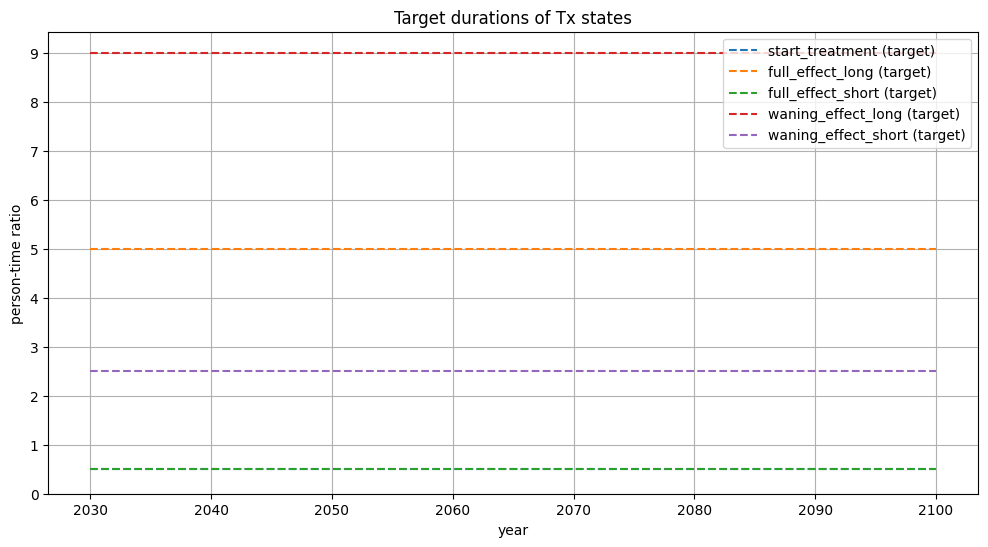

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

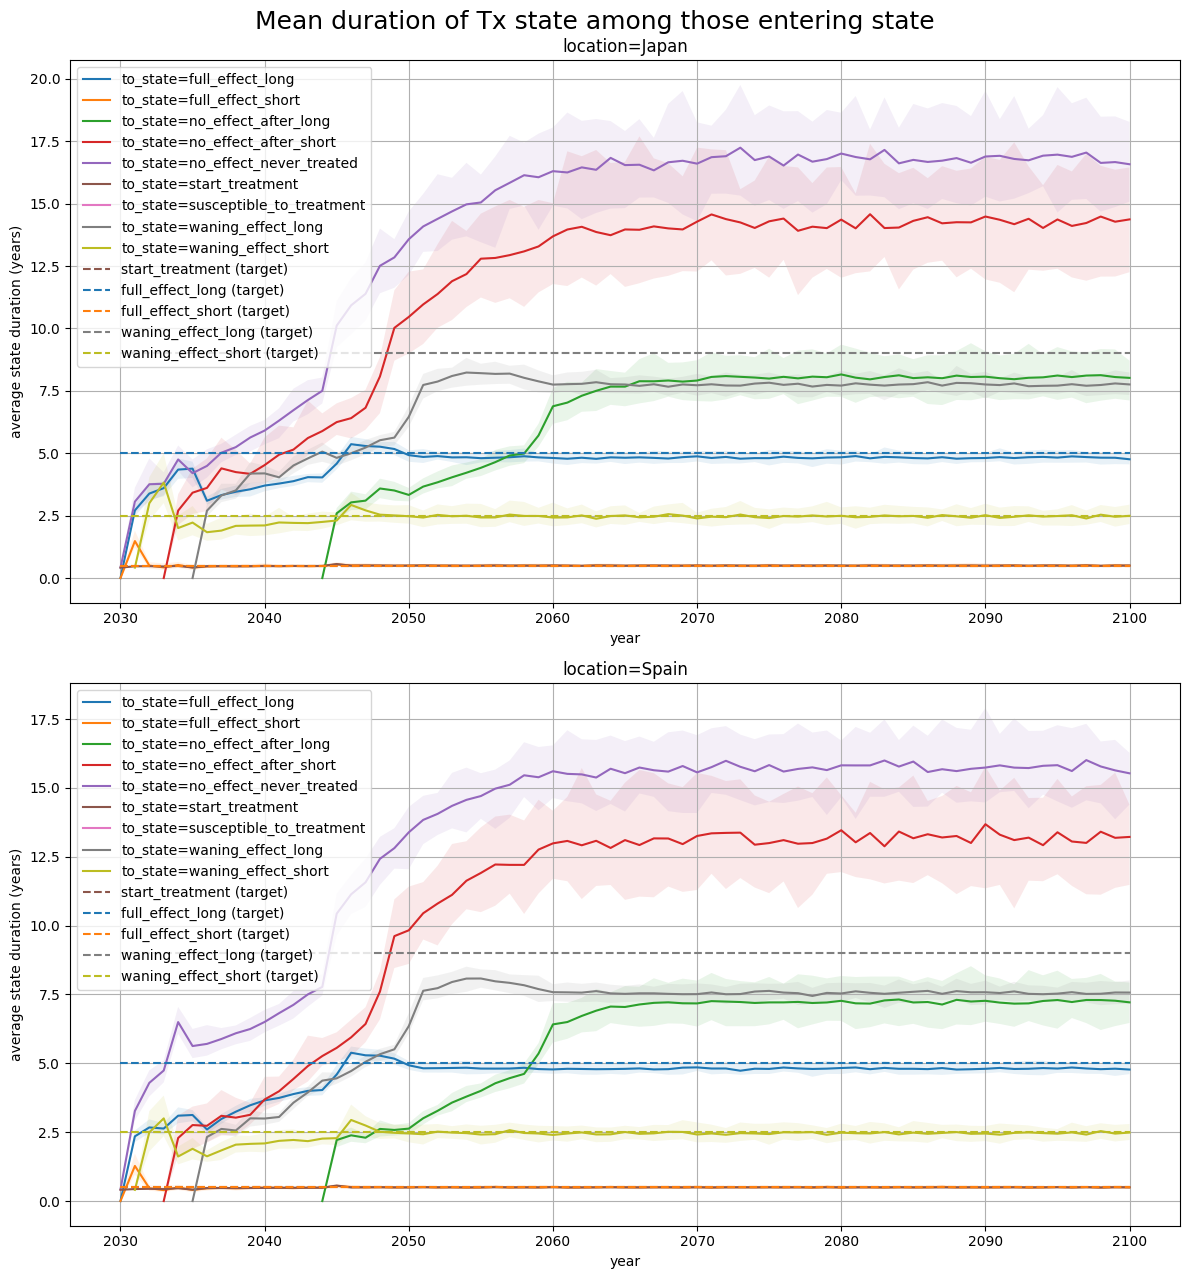

In [53]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    # ax.semilogy()
plt.show()

In [54]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

,event_year,from_state,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2030,full_effect_long,2,bbbm_testing_and_treatment,Japan,NaN,person_time,transition_count,1
1,2030,full_effect_long,2,bbbm_testing_and_treatment,Spain,NaN,person_time,transition_count,1
2,2030,full_effect_long,13,bbbm_testing_and_treatment,Japan,NaN,person_time,transition_count,1
3,2030,full_effect_long,13,bbbm_testing_and_treatment,Spain,NaN,person_time,transition_count,1
4,2030,full_effect_long,24,bbbm_testing_and_treatment,Japan,NaN,person_time,transition_count,1
...,...,...,...,...,...,...,...,...,...
31945,2100,waning_effect_short,460,bbbm_testing_and_treatment,Spain,2.575770,person_time,transition_count,1
31946,2100,waning_effect_short,480,bbbm_testing_and_treatment,Japan,2.440598,person_time,transition_count,1
31947,2100,waning_effect_short,480,bbbm_testing_and_treatment,Spain,2.368548,person_time,transition_count,1
31948,2100,waning_effect_short,499,bbbm_testing_and_treatment,Japan,2.629484,person_time,transition_count,1


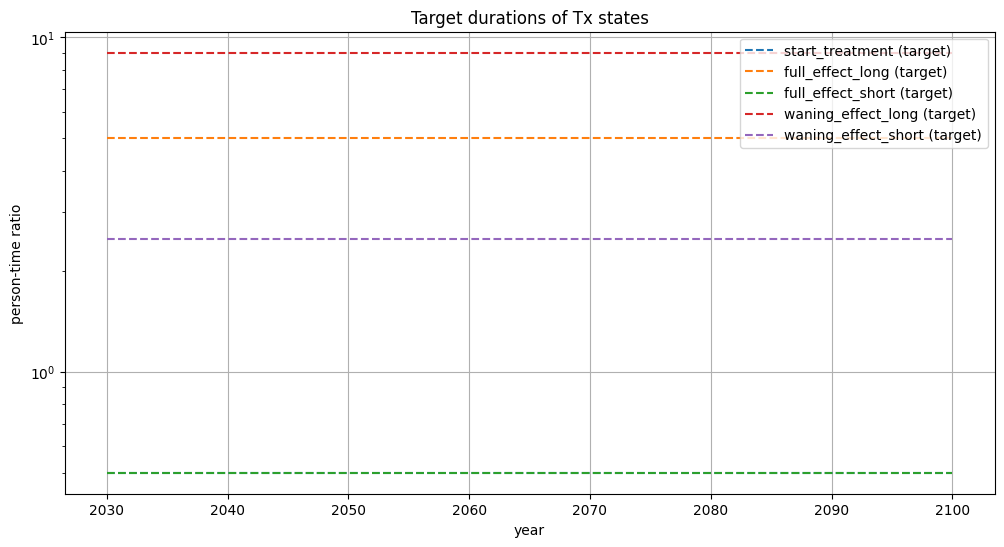

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

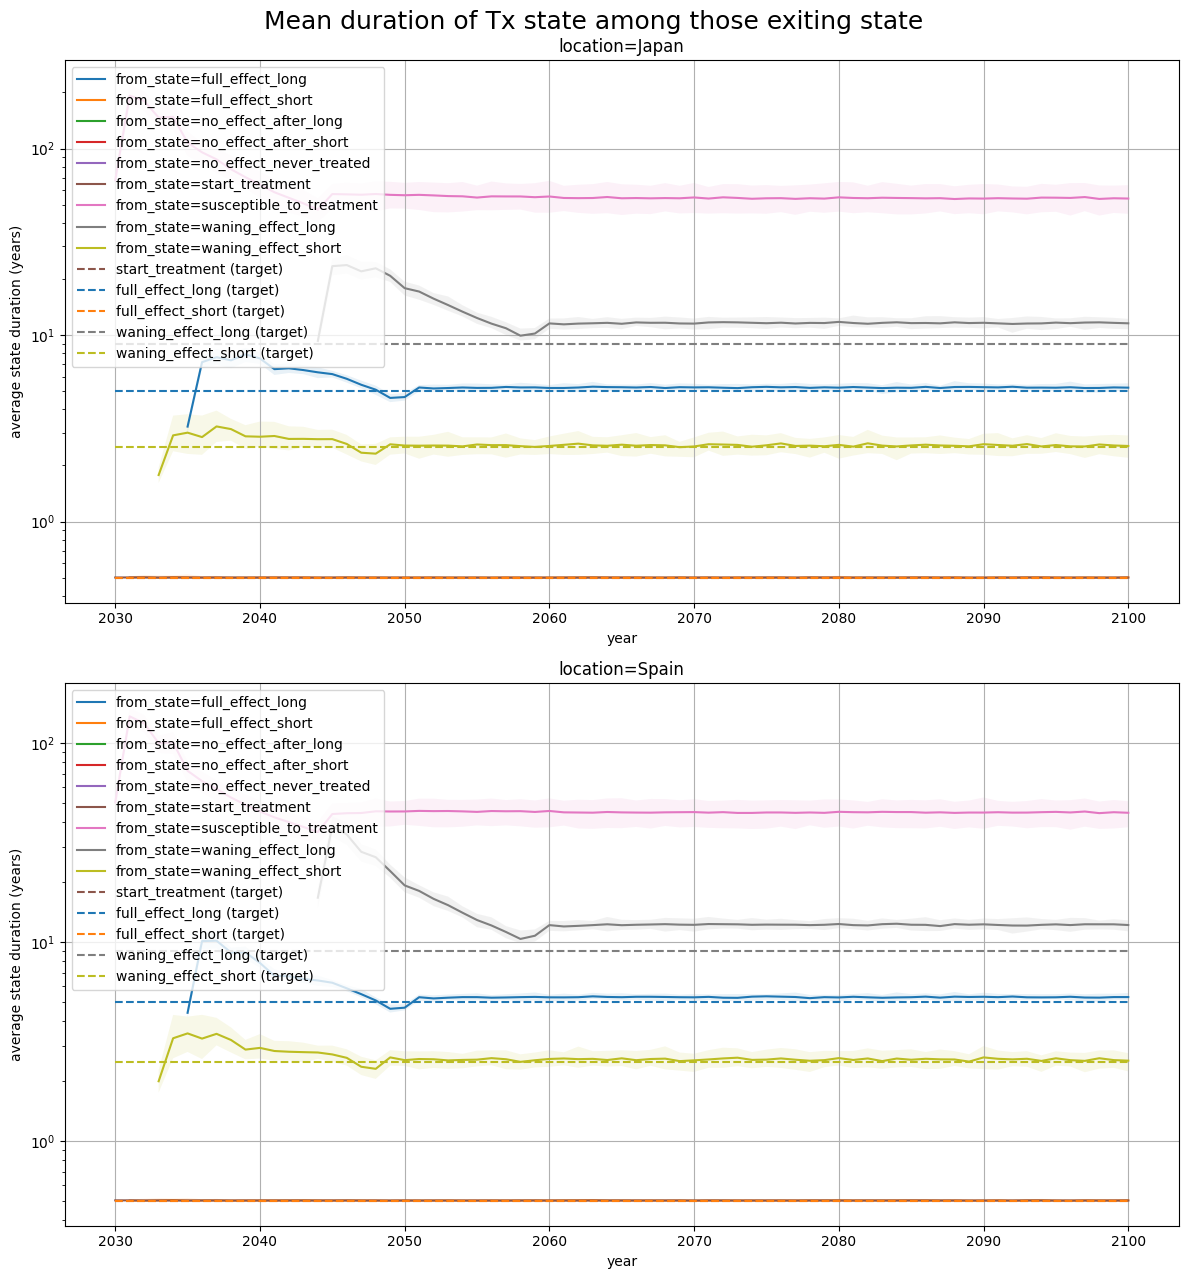

In [56]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [57]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        7.654893
std         0.237668
min         6.928293
25%         7.481280
50%         7.647788
75%         7.806785
max         8.728429
Name: value, dtype: float64

In [58]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean       11.903948
std         0.537389
min        10.066378
25%        11.534593
50%        11.894793
75%        12.263409
max        14.082844
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [59]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        4.815206
std         0.126460
min         4.278850
25%         4.728930
50%         4.811864
75%         4.899790
max         5.371843
Name: value, dtype: float64

In [60]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2060").value.describe()

count    2000.000000
mean        5.260331
std         0.130661
min         4.784958
25%         5.171524
50%         5.259401
75%         5.349511
max         5.832492
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [61]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias'
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
20.526725 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,person_time,baseline,Female,alzheimers_blood_based_biomarker_state,0.000000,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,person_time,baseline,Female,alzheimers_mild_cognitive_impairment_state,0.000000,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,person_time,baseline,Female,alzheimers_disease_state,0.000000,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,person_time,baseline,Male,alzheimers_blood_based_biomarker_state,0.498289,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,person_time,baseline,Male,alzheimers_mild_cognitive_impairment_state,0.000000,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...
1025995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,person_time,bbbm_testing_and_treatment,Female,alzheimers_mild_cognitive_impairment_state,1371.789185,Spain
1025996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,person_time,bbbm_testing_and_treatment,Female,alzheimers_disease_state,2228.845996,Spain
1025997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,person_time,bbbm_testing_and_treatment,Male,alzheimers_blood_based_biomarker_state,761.883641,Spain
1025998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,person_time,bbbm_testing_and_treatment,Male,alzheimers_mild_cognitive_impairment_state,423.545517,Spain


In [62]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias'
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
13.686723 MB
14.374025 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location,from_state,to_state
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,transition_count,baseline,Female,alzheimers_blood_based_biomarker_state_to_alzh...,0.0,Japan,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,transition_count,baseline,Female,alzheimers_mild_cognitive_impairment_state_to_...,0.0,Japan,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,transition_count,baseline,Male,alzheimers_blood_based_biomarker_state_to_alzh...,0.0,Japan,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,transition_count,baseline,Male,alzheimers_mild_cognitive_impairment_state_to_...,0.0,Japan,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,transition_count,bbbm_testing,Female,alzheimers_blood_based_biomarker_state_to_alzh...,0.0,Japan,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,transition_count,bbbm_testing,Male,alzheimers_mild_cognitive_impairment_state_to_...,109.0,Spain,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,transition_count,bbbm_testing_and_treatment,Female,alzheimers_blood_based_biomarker_state_to_alzh...,249.0,Spain,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,transition_count,bbbm_testing_and_treatment,Female,alzheimers_mild_cognitive_impairment_state_to_...,326.0,Spain,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2100,273,transition_count,bbbm_testing_and_treatment,Male,alzheimers_blood_based_biomarker_state_to_alzh...,66.0,Spain,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state


In [63]:
transition_rates = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states,
    strata=[],
)

# Load deaths and plot averted deaths by scenario

In [64]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])
13.002392 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,baseline,Male,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing,Male,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing_and_treatment,Female,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,baseline,Male,349.0,Spain
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,bbbm_testing,Female,1084.0,Spain
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,bbbm_testing,Male,349.0,Spain
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,bbbm_testing_and_treatment,Female,1116.0,Spain


In [65]:
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

13.002392 MB measure
6.16226 MB minuend
12.31826 MB subtrahend
4.113556 MB minuend re-indexed
8.217556 MB subtrahend re-indexed
8.217616 MB difference
11.406392 MB difference with reset index
11.862717 MB final difference
11.862717 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,sex,location,scenario,subtracted_from,value
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Female,Japan,bbbm_testing,baseline,0.0
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Male,Japan,bbbm_testing,baseline,0.0
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Female,Japan,bbbm_testing_and_treatment,baseline,0.0
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Male,Japan,bbbm_testing_and_treatment,baseline,0.0
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,89,deaths,Female,Japan,bbbm_testing,baseline,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
455995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,Male,Spain,bbbm_testing_and_treatment,baseline,-5.0
455996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,Female,Spain,bbbm_testing,baseline,0.0
455997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,Male,Spain,bbbm_testing,baseline,0.0
455998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,Female,Spain,bbbm_testing_and_treatment,baseline,-32.0


In [66]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456000 entries, 0 to 455999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        456000 non-null  category
 1   artifact_path    456000 non-null  category
 2   entity           456000 non-null  category
 3   entity_type      456000 non-null  category
 4   event_year       456000 non-null  int64   
 5   input_draw       456000 non-null  category
 6   measure          456000 non-null  category
 7   sex              456000 non-null  category
 8   location         456000 non-null  category
 9   scenario         456000 non-null  category
 10  subtracted_from  456000 non-null  category
 11  value            456000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 11.3 MB


In [67]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [68]:
averted_deaths.index.memory_usage(deep=True)

132

In [69]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [70]:
averted_deaths.value.describe()

count    456000.000000
mean          0.088325
std           3.918592
min         -66.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: value, dtype: float64

In [71]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

11.862717 MB


In [72]:
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

11.862717 MB
4.587667 MB


,entity,age_group,event_year,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_disease_state,40_to_44,2027,499,bbbm_testing,Spain,0.000000,deaths,deaths,100
1,alzheimers_disease_state,40_to_44,2027,499,bbbm_testing_and_treatment,Spain,0.000000,deaths,deaths,100
2,alzheimers_disease_state,40_to_44,2027,265,bbbm_testing,Spain,0.000000,deaths,deaths,100
3,alzheimers_disease_state,40_to_44,2027,265,bbbm_testing_and_treatment,Spain,0.000000,deaths,deaths,100
4,alzheimers_disease_state,40_to_44,2027,262,bbbm_testing,Spain,0.000000,deaths,deaths,100
...,...,...,...,...,...,...,...,...,...,...
147845,other_causes,95_plus,2100,258,bbbm_testing_and_treatment,Spain,-1.191766,deaths,deaths,100
147846,other_causes,95_plus,2100,273,bbbm_testing,Japan,0.000000,deaths,deaths,100
147847,other_causes,95_plus,2100,273,bbbm_testing,Spain,0.000000,deaths,deaths,100
147848,other_causes,95_plus,2100,273,bbbm_testing_and_treatment,Japan,-1.791868,deaths,deaths,100


In [73]:
averted_deaths_pct.memory_usage(deep=True)

Index                      132
entity                  148108
age_group               149380
event_year             1182800
input_draw              148606
scenario                148175
location                148824
value                  1182800
numerator_measure       148021
denominator_measure     148021
multiplier             1182800
dtype: int64

In [74]:
ops.stratify(averted_deaths, 'event_year')

,event_year,input_draw,scenario,location,value
0,2025,24,bbbm_testing,Japan,0.0
1,2025,24,bbbm_testing,Spain,0.0
2,2025,24,bbbm_testing_and_treatment,Japan,0.0
3,2025,24,bbbm_testing_and_treatment,Spain,0.0
4,2025,89,bbbm_testing,Japan,0.0
...,...,...,...,...,...
7595,2100,258,bbbm_testing_and_treatment,Spain,6.0
7596,2100,273,bbbm_testing,Japan,0.0
7597,2100,273,bbbm_testing,Spain,0.0
7598,2100,273,bbbm_testing_and_treatment,Japan,4.0


In [75]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [76]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}


In [77]:
f(2)

2 () {}


# Draw results plots

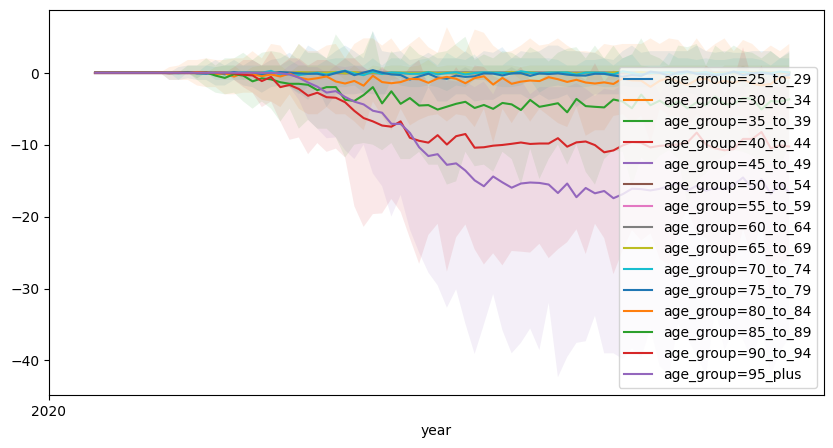

In [78]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()


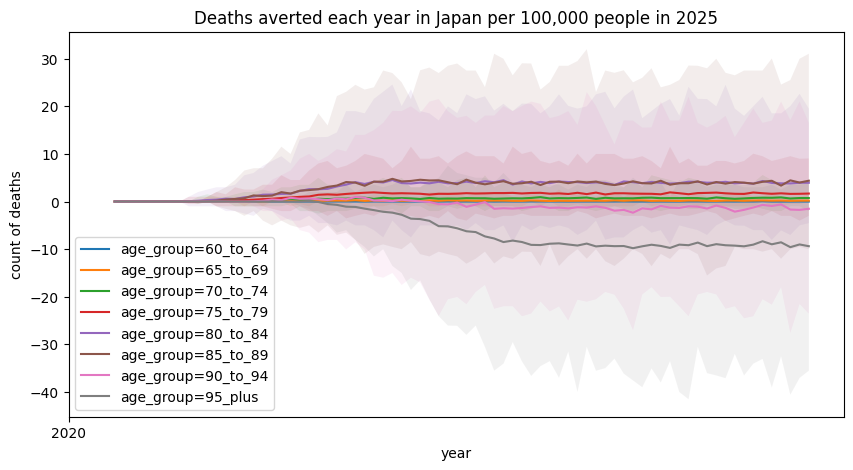

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

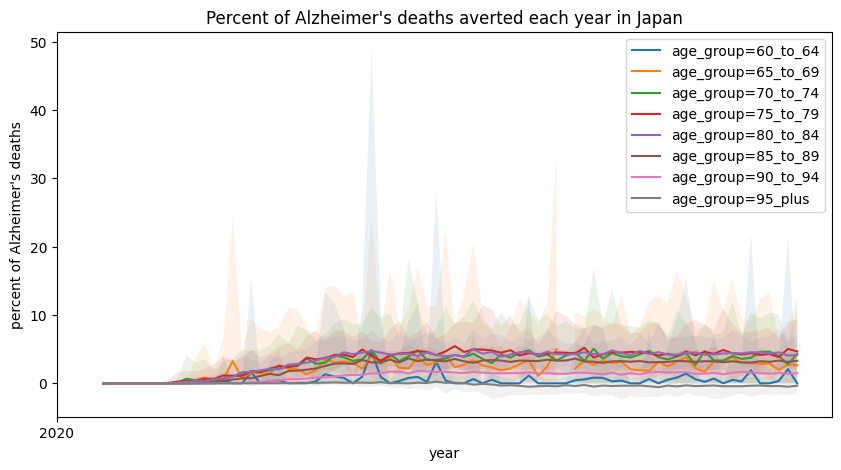

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [81]:
deaths.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

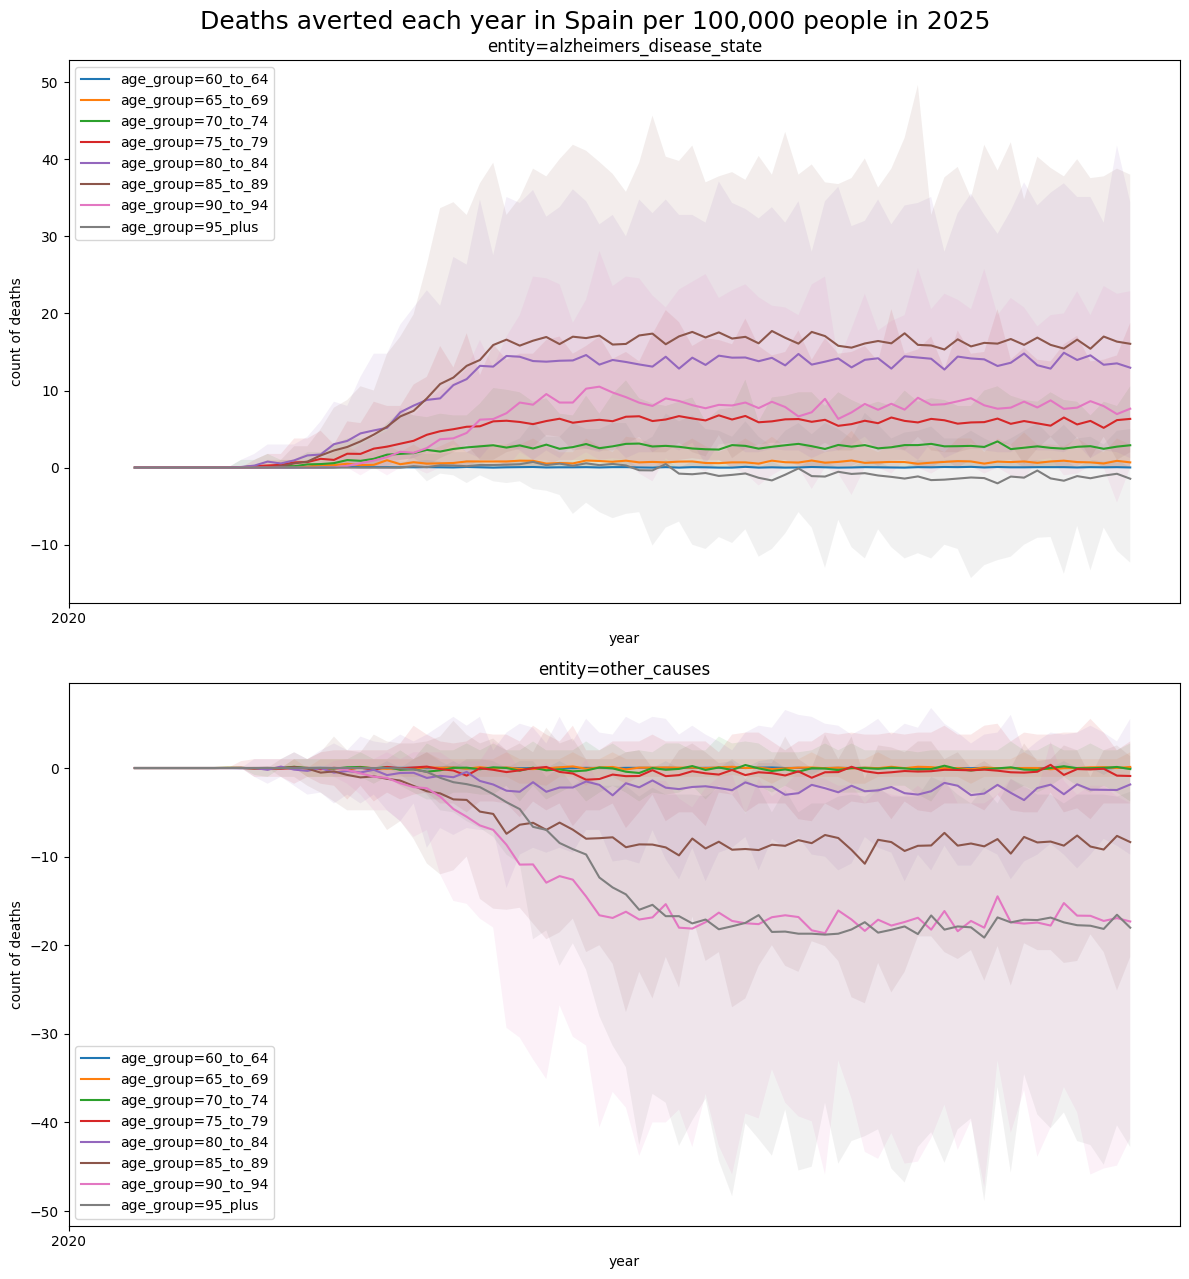

In [82]:
location = locations[1]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
plt.show()

# Absolute reductions in AD deaths for all countries

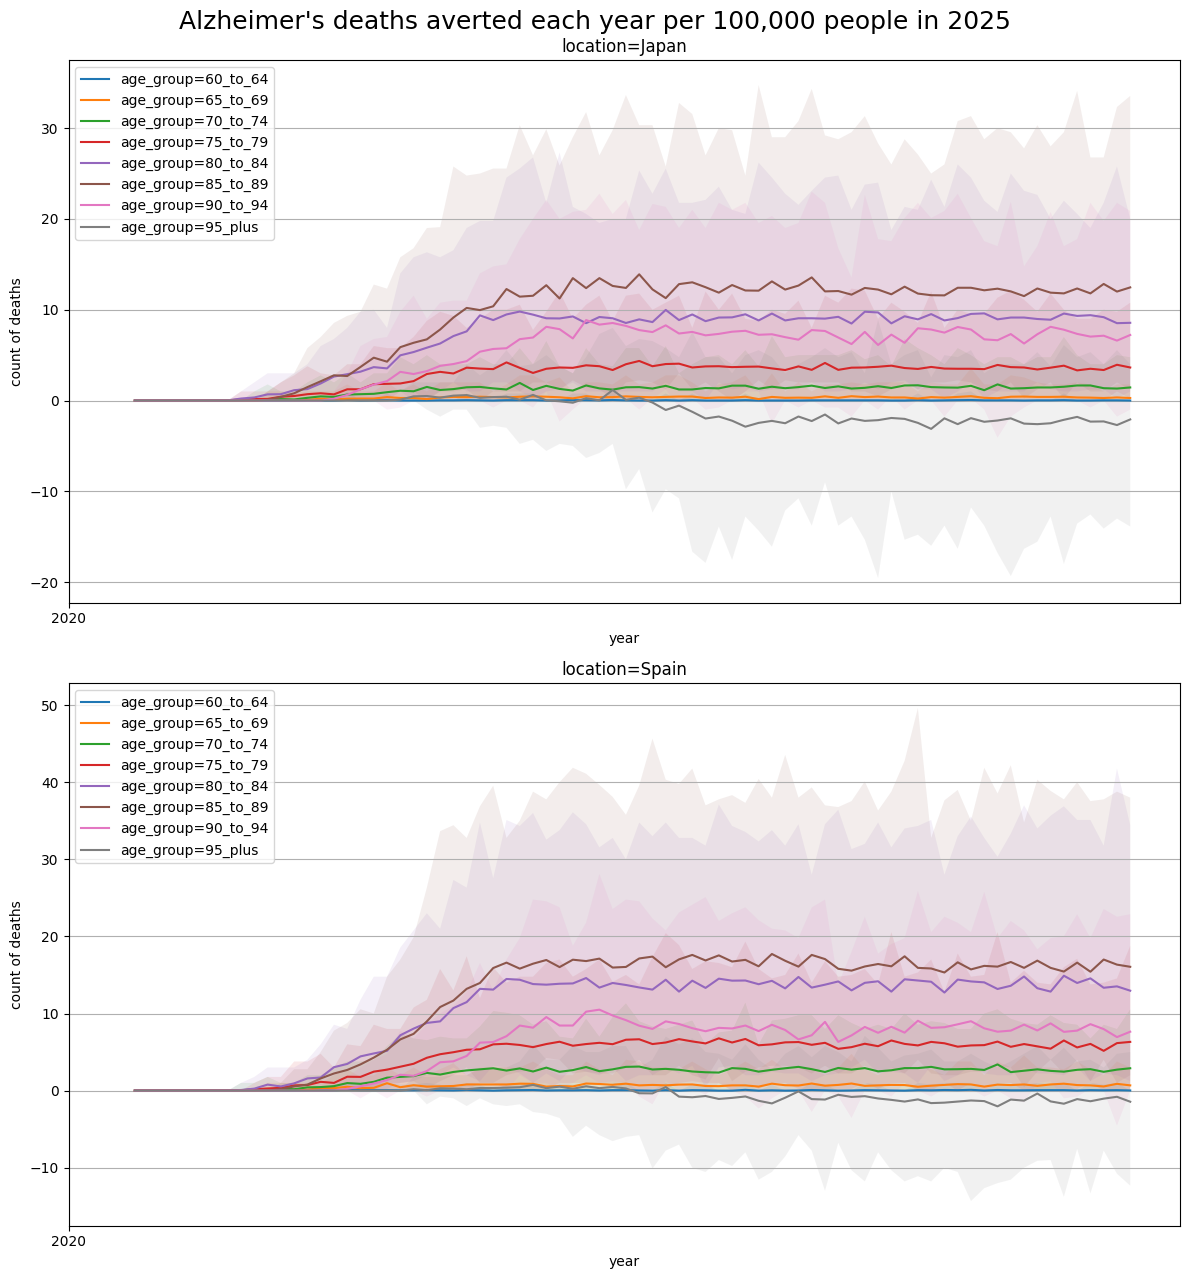

In [83]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

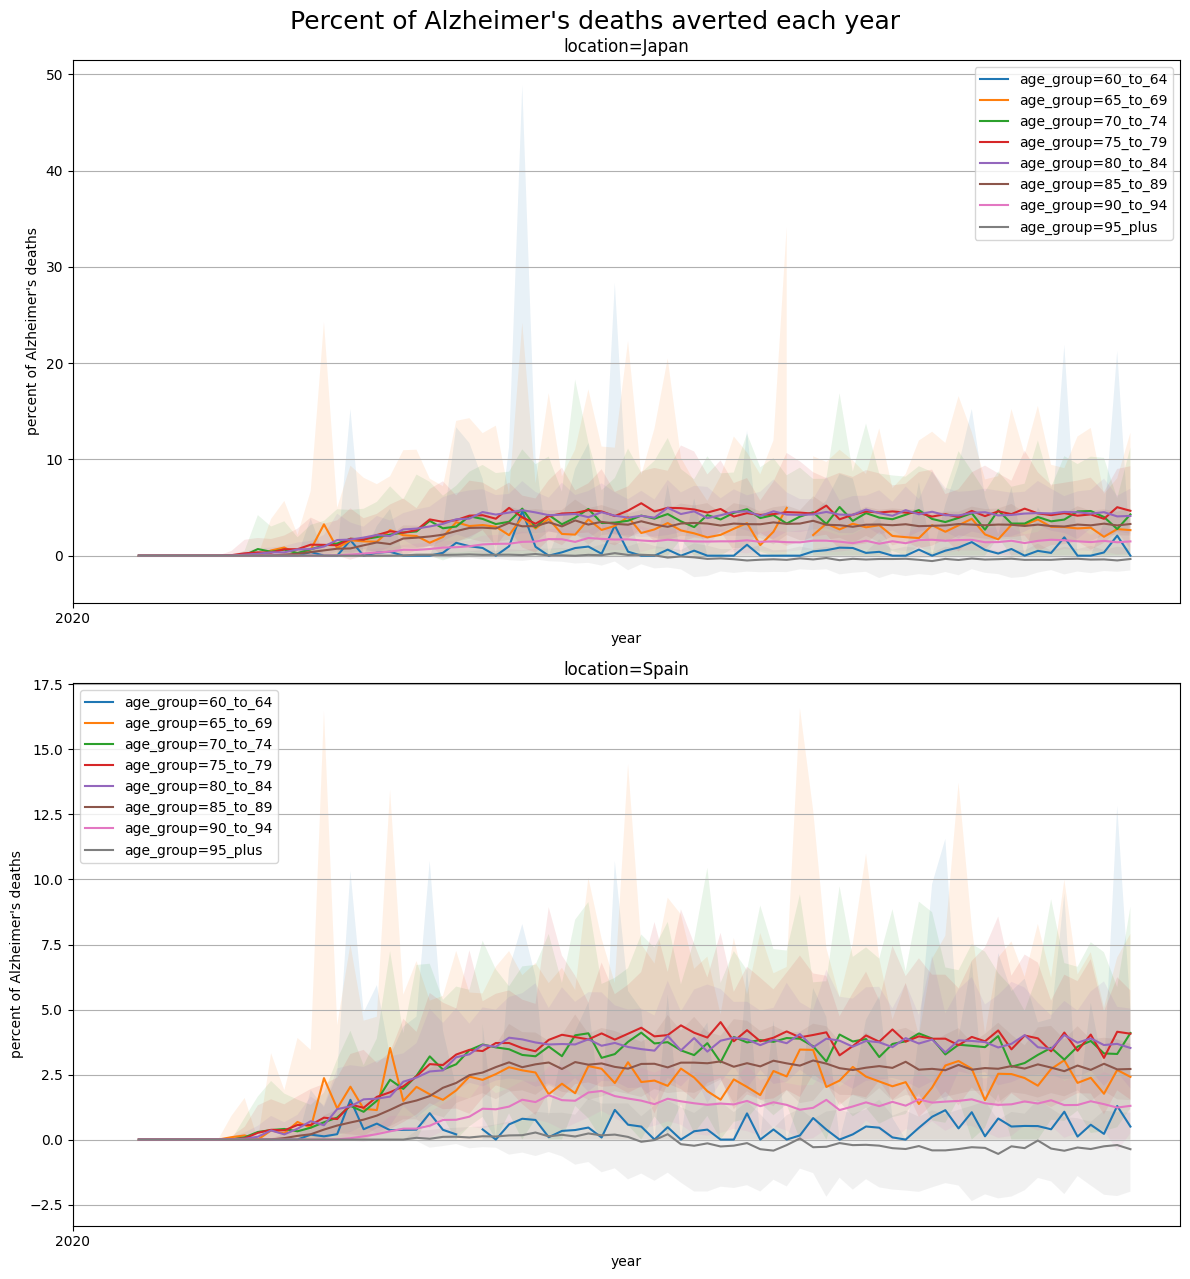

In [84]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Try loading YLDs

In [85]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/spain.hdf'])


82.087715 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,ylds,baseline,Female,alzheimers_blood_based_biomarker_state,0.000000,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,ylds,baseline,Female,alzheimers_mild_cognitive_impairment_state,0.000000,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,ylds,baseline,Female,alzheimers_disease_state,0.000000,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,ylds,baseline,Male,alzheimers_blood_based_biomarker_state,0.000000,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,24,ylds,baseline,Male,alzheimers_mild_cognitive_impairment_state,0.000000,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...
4103995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,273,ylds,baseline,Male,all_causes,228.825503,Spain
4103996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,273,ylds,bbbm_testing,Female,all_causes,915.451368,Spain
4103997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,273,ylds,bbbm_testing,Male,all_causes,228.825503,Spain
4103998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,273,ylds,bbbm_testing_and_treatment,Female,all_causes,931.144837,Spain


In [86]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
convert_dtypes(averted_ylds, colname_to_categorical_dtype, inplace=True)
print_memory_usage(averted_ylds)
convert_to_categorical(averted_ylds, inplace=True)
print_memory_usage(averted_ylds)

82.087715 MB measure
38.311583 MB minuend
76.615583 MB subtrahend
26.002951 MB minuend re-indexed
51.994951 MB subtrahend re-indexed
51.995011 MB difference
71.143715 MB difference with reset index
73.88004 MB final difference
73.88004 MB
57.46404 MB
54.730752 MB


In [87]:
1086.443257 / 27.372526

39.69101196579373

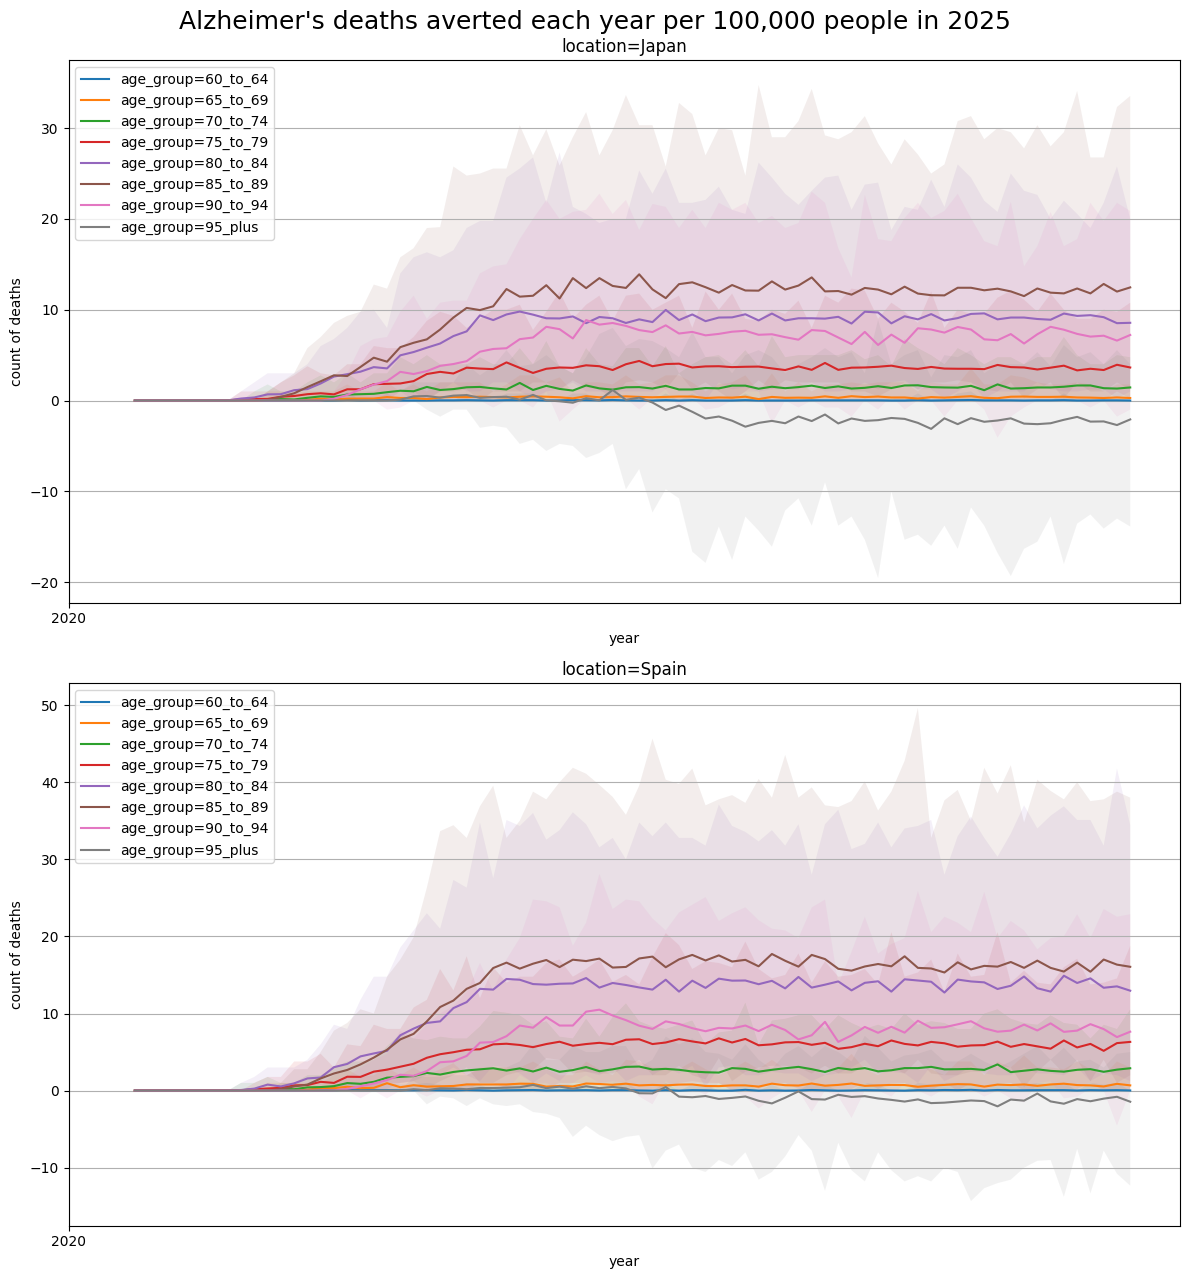

In [88]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()